In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential  

In [2]:
api_key = '8b56d8c493094900a6580e5ac32b536d'
symbol = 'BTC/USD'
interval = '5min'
order = 'asc'
start_date = '2022-07-13 00:00:00'
end_date = '2022-08-03 00:00:00'
api_url = f'https://api.twelvedata.com/time_series?apikey={api_key}&symbol={symbol}&start_date={start_date}&end_date={end_date}&interval={interval}&order={order}'

In [3]:
import requests
data=requests.get(api_url).json()
# print(data.json())

In [4]:
df = pd.DataFrame(data['values'])

In [5]:
df

,datetime,open,high,low,close
0,2022-07-16 15:25:00,20894.22070,20924.98047,20894.22070,20909.22070
1,2022-07-16 15:30:00,20909.39062,20922.26953,20888.17969,20902.58984
2,2022-07-16 15:35:00,20899.33984,20920.75000,20890.86914,20890.86914
3,2022-07-16 15:40:00,20891.24023,20900.33984,20882.36914,20898.71094
4,2022-07-16 15:45:00,20900.33984,20914.94922,20889.98047,20914.94922
...,...,...,...,...,...
4995,2022-08-02 23:40:00,23050.08984,23083.75977,23049.58984,23079.52930
4996,2022-08-02 23:45:00,23079.47070,23081.74023,23025.35938,23044.75977
4997,2022-08-02 23:50:00,23062.28906,23065.92969,22956.27930,22957.19922
4998,2022-08-02 23:55:00,22966.83984,22997.56055,22951.33984,22995.08984


In [6]:
#scale the data between 0 and 1 for easier analysis
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1,1))

In [7]:
scaled_data.shape

(5000, 1)

In [8]:
time_intervals_to_train = 24 #from last 2 hours data 24*5min=120min
prediction_interval = 12 #predict next hour data, 36th interval~item
x_train = []
y_train = []

In [9]:
for i in range(time_intervals_to_train, len(scaled_data)-prediction_interval):
  x_train.append(scaled_data[i-time_intervals_to_train:i,0])
  y_train.append(scaled_data[i+prediction_interval, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [11]:
x_train.shape

(4964, 24, 1)

In [12]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],1), activation='relu'))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


In [13]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


In [14]:
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
78/78 [==============================] - 19s 73ms/step - loss: 0.0272 - accuracy: 4.0290e-04
Epoch 2/10
78/78 [==============================] - 5s 63ms/step - loss: 0.0052 - accuracy: 4.0290e-04
Epoch 3/10
78/78 [==============================] - 5s 61ms/step - loss: 0.0047 - accuracy: 4.0290e-04
Epoch 4/10
78/78 [==============================] - 4s 54ms/step - loss: 0.0045 - accuracy: 4.0290e-04
Epoch 5/10
78/78 [==============================] - 5s 58ms/step - loss: 0.0044 - accuracy: 4.0290e-04
Epoch 6/10
78/78 [==============================] - 5s 60ms/step - loss: 0.0042 - accuracy: 4.0290e-04
Epoch 7/10
78/78 [==============================] - 4s 47ms/step - loss: 0.0041 - accuracy: 4.0290e-04
Epoch 8/10
78/78 [==============================] - 4s 53ms/step - loss: 0.0040 - accuracy: 4.0290e-04
Epoch 9/10
78/78 [==============================] - 4s 53ms/step - loss: 0.0039 - accuracy: 4.0290e-04
Epoch 10/10
78/78 [==============================] - 4s 49ms/step - loss

In [15]:
test_start = '2022-08-03 00:00:00'
test_end = '2022-08-10 00:00:00'

test_api_url = api_url = f'https://api.twelvedata.com/time_series?apikey={api_key}&symbol={symbol}&start_date={test_start}&end_date={test_end}&interval={interval}&order={order}'
td = requests.get(test_api_url).json()
td = pd.DataFrame(td['values'])

td



,datetime,open,high,low,close
0,2022-08-03 00:00:00,22995.08984,23015.34961,22975.69922,22975.69922
1,2022-08-03 00:05:00,22988.44922,23069.78906,22975.69922,23059.14062
2,2022-08-03 00:10:00,23052.89062,23065.14062,22959.83008,22959.83008
3,2022-08-03 00:15:00,22963.19922,22964.46094,22932.36914,22946.17969
4,2022-08-03 00:20:00,22940.99023,22944.28906,22864.94922,22908.50000
...,...,...,...,...,...
2012,2022-08-09 23:40:00,23193.09961,23205.25977,23190.75977,23191.93945
2013,2022-08-09 23:45:00,23190.75977,23195.24023,23165.53906,23166.80078
2014,2022-08-09 23:50:00,23165.53906,23173.58008,23150.61914,23164.57031
2015,2022-08-09 23:55:00,23165.22070,23165.91992,23142.60938,23152.31055


In [16]:
bitcoinPrices = pd.to_numeric(td['close'], errors='coerce').values
test_inputs = td['close'].values
test_inputs = test_inputs.reshape(-1,1)
model_inputs=scaler.fit_transform(test_inputs)

In [17]:
x_test = []
for x in range(time_intervals_to_train, len(model_inputs)):
  x_test.append(model_inputs[x-time_intervals_to_train:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [18]:
prediction_prices = model.predict(x_test)

63/63 [==============================] - 3s 22ms/step


In [19]:
prediction_prices = scaler.inverse_transform(prediction_prices)

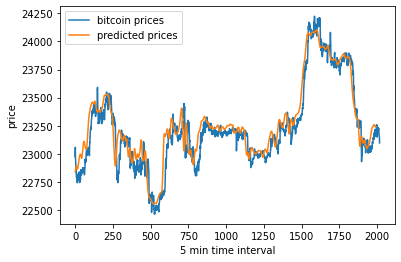

In [20]:
plt.plot(bitcoinPrices, label = 'bitcoin prices')
plt.plot(prediction_prices, label = 'predicted prices')
plt.xlabel('5 min time interval')
plt.ylabel('price')
plt.legend()
plt.show()